# How to generate a lens using _lenstronomy_

In [1]:
import os
import sys
import pickle as pkl
import h5py
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.Util import kernel_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

from slitronomy.Util.plot_util import nice_colorbar

from util import galsim_util

%matplotlib inline

In [2]:
background_rms = 0.01  # background noise per pixel
#exp_time = 10000 # 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

num_pix = 69
delta_pix = 0.08
source_amp = 200

psf_num_pix = 41
psf_fwhm = 0.2

supersampling_res_sim = 3
num_pix_source = int(num_pix * supersampling_res_sim)
delta_pix_source = delta_pix / supersampling_res_sim

In [3]:
save_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/lenstro_sims'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

def save_fits(data, file_path, overwrite=True):
    hdu = pf.PrimaryHDU(data)
    hdu.writeto(file_path, overwrite=overwrite)
    print("FITS file successfully saved to", file_path)
    
def dump_pickle(data, path, protocol=None):
    if protocol is None:
        protocol = 2
    with open(path, 'wb') as handle:
        pkl.dump(data, handle, protocol=protocol)

def save_hdf5(data_dict, path):
    with h5py.File(path, "w") as f:
        for name, data in data_dict.items():
            dset = f.create_dataset(name, data=data)

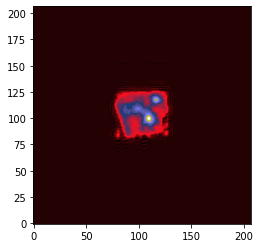

In [4]:
# generate the source from galsim
galsim_index = 31
galsim_scale = 1
source_image, _ = galsim_util.get_galsim_image(index=galsim_index, image_size=num_pix_source, 
                                               pixel_size=delta_pix_source, image_scale=galsim_scale)
source_image /= source_image.max() # standardize image

plt.imshow(source_image, origin='lower', cmap='gist_stern')
plt.show()

In [5]:
# data specification (coordinates, etc.)
#kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, inverse=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 1., 'gamma': 2., 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = [] # ['SERSIC']
kwargs_sersic = {'amp': 200., 'R_sersic': 10., 'n_sersic': 1, 'center_x': num_pix/2., 'center_y': num_pix/2.}
kwargs_lens_light = [] # [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# interpolation from  an image
source_model_list = ['INTERPOL']
ra_source, dec_source = 0, 0  # in delta_pix units
kwargs_interpol = {'image': source_image, 'amp': source_amp, 'scale': delta_pix_source, 
                   'phi_G': 0, 'center_x': ra_source, 'center_y': dec_source}
kwargs_source = [kwargs_interpol]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_numerics = {'supersampling_factor': supersampling_res_sim, 'supersampling_convolution': False}

In [6]:
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)

#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise

noise_map = bkg * np.ones_like(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['noise_map'] = noise_map
data_class.update_data(image_sim)

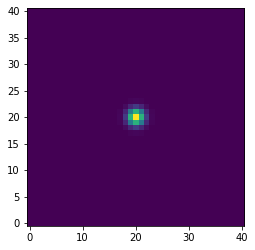

In [7]:
plt.imshow(psf_class.kernel_point_source, origin='lower')
plt.show()
plt.show()

In [8]:
# get the source surface brightness only, in source or image plane
image_sim_source_delensed = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, 
                                                                 unconvolved=False, de_lensed=True)
image_sim_source_lensed   = imageModel.source_surface_brightness(kwargs_source, kwargs_lens=kwargs_lens, 
                                                                 unconvolved=False, de_lensed=False)

In [9]:
# get the convergence map
x_grid, y_grid = data_class.pixel_coordinates
x_grid1d = lenstro_util.image2array(x_grid)
y_grid1d = lenstro_util.image2array(y_grid)
kappa_result1d = lens_model_class.kappa(x_grid1d, y_grid1d, kwargs_lens)
kappa_result = lenstro_util.array2image(kappa_result1d)

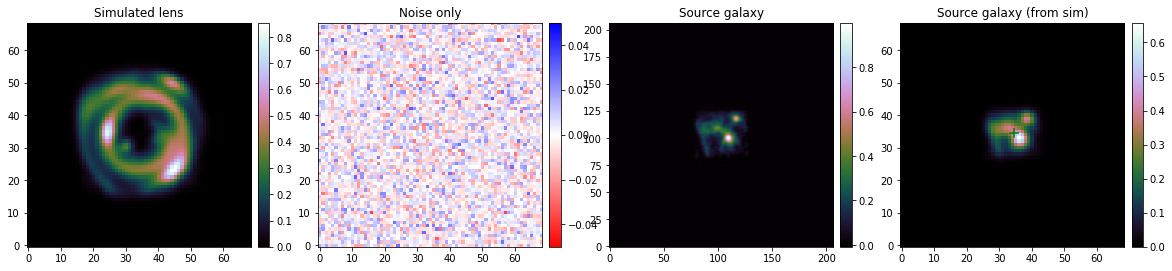

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

ax = axes[0]
ax.set_title("Simulated lens")
im = ax.imshow((image_sim_source_lensed), origin='lower', cmap='cubehelix')
#ax.scatter(numPix/2., numPix/2., color='blue', marker='.', s=40, alpha=0.5) # center of the image
nice_colorbar(im)

ax = axes[1]
ax.set_title("Noise only")
im = ax.imshow(image_sim - image_sim_no_noise, origin='lower', cmap='bwr_r', vmin=-5*background_rms, vmax=5*background_rms)
nice_colorbar(im)

ax = axes[2]
ax.set_title("Source galaxy")
im = ax.imshow((source_image), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = axes[3]
ax.set_title("Source galaxy (from sim)")
im = ax.imshow((image_sim_source_delensed), origin='lower', cmap='cubehelix')
ax.scatter(num_pix/2., num_pix/2., color='green', marker='+', s=120) # center of the image
nice_colorbar(im)

plt.show()

In [11]:
save_fits(image_sim, os.path.join(save_dir, 'lensgen_image_noisy_lenstro.fits'))
save_fits(image_sim_source_lensed + noise, os.path.join(save_dir, 'lensgen_source_noisy_lenstro.fits'))
save_fits(image_sim_source_delensed, os.path.join(save_dir, 'lensgen_source_unlensed_lenstro.fits'))
save_fits(noise, os.path.join(save_dir, 'lensgen_noise_lenstro.fits'))

FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/lenstro_sims/lensgen_image_noisy_lenstro.fits
FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/lenstro_sims/lensgen_source_noisy_lenstro.fits
FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/lenstro_sims/lensgen_source_unlensed_lenstro.fits
FITS file successfully saved to /Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Simulations/lenstro_sims/lensgen_noise_lenstro.fits
